In [1]:
import os
import sys
import shutil
from functools import reduce

import numpy as np

sys.path.append('../../..')

from seismicpro.batchflow import Pipeline, B, I, D, L

from seismicpro.src import SeismicDataset, FieldIndex, merge_segy_files


In [3]:
def normalise_ds(paths):
    
    field_index = FieldIndex(name='raw', path=paths['raw'], extra_headers='all')
    field_index = reduce(lambda x, y: x.merge(y), 
                         (FieldIndex(name=name, path=path) for name, path in paths.items() if name != 'raw'),
                         field_index)
    print("Fields:", len(field_index))

    field_set = SeismicDataset(field_index)
    
    comp = list(paths.keys())
    
    first_preproc_ppl = (
        field_set.pipeline()
        .load(fmt='sgy', components=comp)
        .find_equalization_params(B(), component='raw', survey_id_col='YearDataRecorded', container_name='equal_params')
        .run_later(batch_size=5, n_epochs=1, shuffle=False, drop_last=False, bar=True)
        )
    first_preproc_ppl.run()
    
    tmp_dump_path = 'tmp'
    if os.path.exists(tmp_dump_path):
        shutil.rmtree(tmp_dump_path)
    
    os.makedirs(tmp_dump_path)

    
    ppl2 = field_set.pipeline().load(fmt='sgy', components=comp)  
    ppl2 = reduce(lambda ppl, comp: (ppl
                                     .equalize(src=comp, dst=comp, params=D('equal_params'))
                                     .dump(path=L(lambda x: os.path.join(tmp_dump_path, comp + str(x) + '.sgy'))(I()), src=comp, fmt='segy', split=False)),
                  paths, ppl2)
    ppl2 = ppl2.run_later(batch_size=5, n_epochs=1, shuffle=False, drop_last=False, bar=True)
    
    ppl2.after = reduce(lambda ppl, comp: ppl.merge_segy_files(output_path=paths[comp].replace('.sgy', '_norm2.sgy'), 
                                                               extra_headers='all', path=os.path.join(tmp_dump_path, comp + '*.sgy')),
                        paths, ppl2.after)
    ppl2.run()
    
    if os.path.exists(tmp_dump_path):
        shutil.rmtree(tmp_dump_path)


In [4]:
base_path = '/notebooks/data/H1_WZ'
paths = dict(raw = os.path.join(base_path, '1_NA-gr_input_DN01.sgy'), lift = os.path.join(base_path, '1_NA-gr_output_DN03.sgy'))

normalise_ds(paths)

  0%|          | 0/21 [00:00<?, ?it/s]

Fields: 101


../../../seismicpro/batchflow/batchflow/batch.py:297: UserWarning: All batch data is erased
  warnings.warn("All batch data is erased")
100%|██████████| 21/21 [00:40<00:00,  2.14s/it]


In [3]:
base_path = '/notebooks/data/noise_dataset_1'
paths = dict(raw = os.path.join(base_path, 'DN02A_LIFT_AMPSCAL.sgy'), lift = os.path.join(base_path, 'DN02B_SHOTS_LIFT1.sgy'))

normalise_ds(paths)

100%|██████████| 11/11 [00:42<00:00,  4.11s/it]


In [13]:
base_path = os.path.join('/notebooks/data/', 'YL1_UKM')
paths = dict(raw = os.path.join(base_path, '01_NA-gr_input_prep.sgy'),
             lift1 = os.path.join(base_path, '02_NA-gr_output_lift1_fdnat.sgy'),
             lift2 = os.path.join(base_path, '03_NA-gr_output_lift2_agora.sgy'))

normalise_ds(paths)

100%|██████████| 10/10 [01:07<00:00,  7.03s/it]


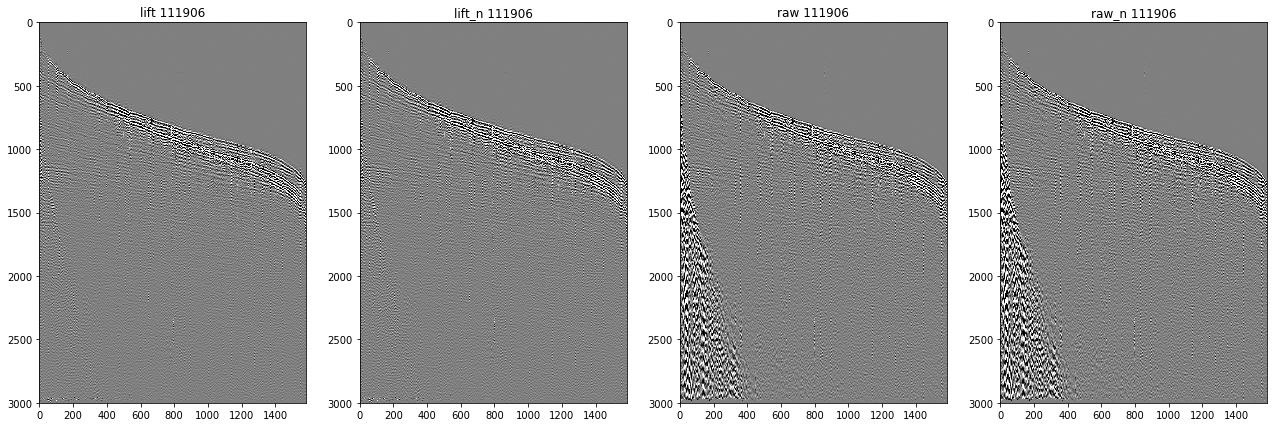

In [5]:
data_path = 'H1_WZ' 

paths = {
    'lift': '1_NA-gr_output_DN03.sgy',
    'raw': '1_NA-gr_input_DN01.sgy',
    'lift_n': '1_NA-gr_output_DN03_norm2.sgy',
    'raw_n': '1_NA-gr_input_DN01_norm2.sgy',
}

base_path = os.path.join('/notebooks/data/', data_path)

field_index = reduce(lambda x, y: x.merge(y), 
                     (FieldIndex(name=name, path=os.path.join(base_path,path), extra_headers=['offset']) for name, path in paths.items()))

components = ('lift', 'lift_n', 'raw', 'raw_n')


(SeismicDataset(field_index).next_batch(1)
         .load(components=components, fmt='segy')
         .sort_traces(src=components, dst=components, sort_by='offset')
         .seismic_plot(components, field_index.indices[0], figsize=(22, 7), vmax=1, vmin=-1, cmap='gray'))

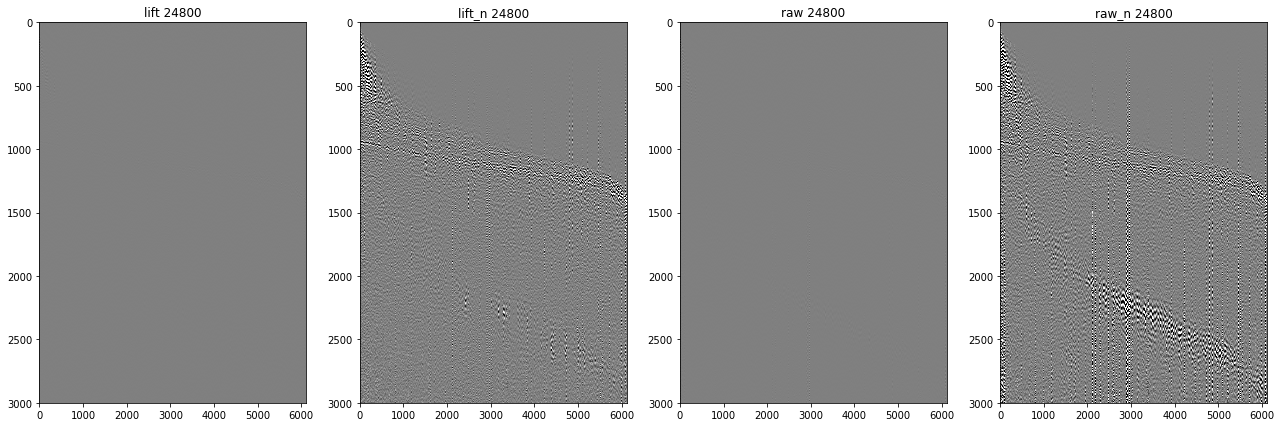

In [21]:
data_path = 'YL1_UKM' 

paths = {
#     'lift': '02_NA-gr_output_lift1_fdnat.sgy',
    'lift': '03_NA-gr_output_lift2_agora.sgy',
    'raw': '01_NA-gr_input_prep.sgy',
    'lift_n': '03_NA-gr_output_lift2_agora_norm2.sgy',
    'raw_n': '01_NA-gr_input_prep_norm2.sgy',
}

base_path = os.path.join('/notebooks/data/', data_path)

field_index = reduce(lambda x, y: x.merge(y), 
                     (FieldIndex(name=name, path=os.path.join(base_path,path), extra_headers=['offset']) for name, path in paths.items()))

components = ('lift', 'lift_n', 'raw', 'raw_n')


(SeismicDataset(field_index).next_batch(1)
         .load(components=components, fmt='segy')
         .sort_traces(src=components, dst=components, sort_by='offset')
         .seismic_plot(components, field_index.indices[0], figsize=(22, 7), vmax=1, vmin=-1, cmap='gray'))

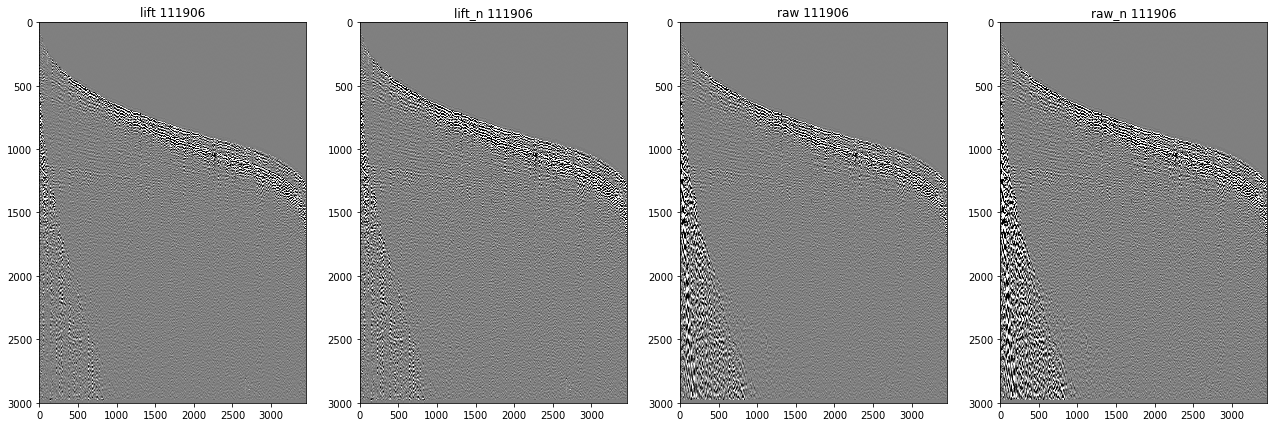

In [4]:
data_path = 'noise_dataset_1'
paths = dict(raw = 'DN02A_LIFT_AMPSCAL.sgy', lift = 'DN02B_SHOTS_LIFT1.sgy', 
            raw_n = 'DN02A_LIFT_AMPSCAL_norm2.sgy', lift_n = 'DN02B_SHOTS_LIFT1_norm2.sgy')

base_path = os.path.join('/notebooks/data/', data_path)

field_index = reduce(lambda x, y: x.merge(y), 
                     (FieldIndex(name=name, path=os.path.join(base_path,path), extra_headers=['offset']) for name, path in paths.items()))

components = ('lift', 'lift_n', 'raw', 'raw_n')


(SeismicDataset(field_index).next_batch(1)
         .load(components=components, fmt='segy')
         .sort_traces(src=components, dst=components, sort_by='offset')
         .seismic_plot(components, field_index.indices[0], figsize=(22, 7), vmax=1, vmin=-1, cmap='gray'))